# <p style="background-color:#9c2162;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">PRODUCT AMOUNT FORECAST BY TIME</p>

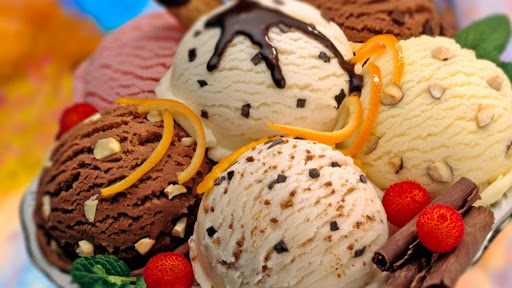

<p style="background-color:#9c2162;font-family:newtimeroman;color:#FFF9ED;font-size:140%;text-align:left;border-radius:10px 10px;">Image credit : http://gubbagroup.com/looking-at-the-evolution-of-the-ice-cream-and-frozen-dessert-market-in-india/</p> 

<a id="toc"></a>

## <h3 style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:center; border-radius:10px 10px;" class="list-group-item list-group-item-action active" data-toggle="list" role="tablist" aria-controls="home">TABLE OF CONTENTS</h3>

* [1) LIBRARIES NEEDED IN THE STUDY](#1)
    * [1.1 User Defined Functions](#1.1)
* [2) DATA](#2)
    * [2.1 Context](#2.1)
    * [2.2 About the Features](#2.2) 
* [3) ANALYSIS](#3)
    * [3.1) Reading the Data](#3)
* [4) EXPLORATORY DATA ANALYSIS (EDA) & VISUALIZATION](#4)
    * [4.1 - A General Looking at the Data](#4.1)
    * [4.2 - Handling with Missing Values](#4.2)  
* [5) DATA PREPROCESSING](#5)
    * [5.1 Train|Test Split Operations](#5.1)
    * [5.2 Scaling Operation](#5.2)
    * [5.3 Time Series Generator](#5.3)
* [6) MODELING & MODEL PERFORMANCE](#6)        
    * [6.1 Creating Model](#6.1)
        * [6.1.1a Modelling With "tanh" Activation Function](#6.1.1a)
        * [6.1.1b EarlyStopping and Validation Generator](#6.1.1b)
        * [6.1.1c Evaluation on Test Data](#6.1.1c)
        * [6.1.1d Inverse Transformations & Comparion](#6.1.1d)
        * [6.1.1e Calculation of R2 Score & Error Metrics](#6.1.1e)
        * [6.1.2a Modelling With "tanh" Activation Function](#6.1.2a)
        * [6.1.2b EarlyStopping and Validation Generator](#6.1.2b)
        * [6.1.2c Evaluation on Test Data](#6.1.2c)
        * [6.1.2d Inverse Transformations & Comparion](#6.1.2d)
        * [6.1.2e Calculation of R2 Score & Error Metrics](#6.1.2e)      
    * [6.2 Retrain & Forecasting](#6.2)

<a id="1"></a>
## <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:center; border-radius:10px 10px;">1 - LIBRARIES NEEDED IN THE STUDY</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

**First, if you do NOT have the following libraries in your kernel, just install them since you have to need them to import some libraries.**

## 1.1. Import Libraries

In [1]:
# !pip install pyforest
# 1-Import Libraies
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import missingno as msno 

from sklearn.compose import make_column_transformer

# Scaling
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


# Importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.express as px
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

# Figure&Display options
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# !pip install termcolor
import colorama
from colorama import Fore, Style  # maakes strings colored
from termcolor import colored

import ipywidgets
from ipywidgets import interact

<a id="1.1"></a>
### <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:LEFT; border-radius:10px 10px;">1.1 User Defined Functions</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

**We have defined some useful user defined functions**

In [2]:
## Some Useful Functions

###############################################################################

def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

###############################################################################

def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('-'*79, 'red', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    
        
def multicolinearity_control(df):
    feature =[]
    collinear=[]
    for col in df.corr().columns:
        for i in df.corr().index:
            if (abs(df.corr()[col][i])> .9 and abs(df.corr()[col][i]) < 1):
                    feature.append(col)
                    collinear.append(i)
                    print(colored(f"Multicolinearity alert in between:{col} - {i}", 
                                  "red", attrs=['bold']), df.shape,'\n',
                                  colored('-'*79, 'red', attrs=['bold']), sep='')

def duplicate_values(df):
    print(colored("Duplicate check...", attrs=['bold']), sep='')
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored("Duplicates were dropped!"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There are no duplicates"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')     
        
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('We will now check the missing values and if necessary will drop realted columns!', attrs=['bold']),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
        
def drop_null(df, limit):
    print('Shape:', df.shape)
    for i in df.isnull().sum().index:
        if (df.isnull().sum()[i]/df.shape[0]*100)>limit:
            print(df.isnull().sum()[i], 'percent of', i ,'null and were dropped')
            df.drop(i, axis=1, inplace=True)
            print('new shape:', df.shape)       
    print('New shape after missing value control:', df.shape)
    
###############################################################################

<a id="2"></a>
## <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:center; border-radius:10px 10px;">2 - DATA</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

**Units: Index 2012=100, Not Seasonally Adjusted**

**Frequency: Monthly**

**The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.**

**NAICS = 31152**

**Source Code: IP.N31152.N**

**Suggested Citation: Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from [FRED, Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/IPN31152N), November 16, 2019.**

**For a better understanding and more information, please refer to [external link text](https://fred.stlouisfed.org/series/IPN31152N)**

<a id="2.1"></a>
### <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:left; border-radius:10px 10px;">2.1 Context</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

**Sequential data means that the data points are interdependent (data at time t is dependent upon data at time t-1).eg Times series data like stock prices, conversations etc. Thus RNNs (Recurrent Neural networks) come into the picture. You can imagine RNNs having a sense of memory which helps them in keeping track of what happened earlier in the sequential data; thus, helping them gain context and identifying correlations and patterns.**

**In this context, this study presents an analysis for prediction of time series of the The industrial production (IP) index using recurrent neural network (RNN). RNNs are deep learning models, typically used to solve problems with sequential input data such as time series.**

<a id="2.2"></a>
### <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:left; border-radius:10px 10px;">2.2 About The Features</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

**The features in the given dataset are: "DATE" and "IPN31152N"**

- **"DATE" column gives a time series of approximately 573 months between 1972 and 2019. So each row in the given dataset will represent data points which are interdependent (data at time t is dependent upon data at time t-1). This column will be set as index to perfom RNN time series at the beginning of the analysis.**

- **The column of "IPN31152N" is the measurement of the real output (production amount by month) of all relevant establishments located in the United States.**

<a id="3"></a>
## <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:center; border-radius:10px 10px;">3 - ANALYSIS</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

<a id="3.1"></a>
### <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:LEFT; border-radius:10px 10px;">3.1 Reading The Data</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

**How to read and assign the dataset as df. [external link text](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) (You can define it as what you want instead of df)**

In [3]:
df0 = pd.read_csv("Frozen_Dessert_Production.csv",
                   index_col='DATE',
                   parse_dates=True)
df = df0.copy()

In [4]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


<a id="4"></a>
## <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:center; border-radius:10px 10px;">4 - EXPLORATORY DATA ANALYSIS (EDA) & VISUALIZATION</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>


**Before performing Machine Learning algorithms, you need to know the data well in order to label the observations correctly. You need to analyze frequency distributions of features, relationships and correlations between the independent variables and the dependent variable. It is recommended to apply data visualization techniques. Observing breakpoints helps you to internalize the data.**

**So, in this Exploratory Data Analysis section the data will be analyzed by summarizing its main characteristics, using statistical graphics and other data visualization methods. As such the reader will be familiar with what the data can tell.**

**The Framework in This Section:**

    1. Implement basic steps to see how is your data looks like
    2. Check for missing values
    3. If there is, drop the features that not suitable for modelling
    4. Implement basic visualization steps such as lineplot

<a id="4.1"></a>
### <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:LEFT; border-radius:10px 10px;">4.1 - A General Looking at the Data</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

**You can use first_looking(df) user defined function above for getting a general insight before going further in the analysis**

In [5]:
first_looking(df)

Shape:(573, 1)
-------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB
None
-------------------------------------------------------------------------------
Number of Uniques:
IPN31152N    573
dtype: int64
-------------------------------------------------------------------------------
Missing Values:
Empty DataFrame
Columns: [Missing_Number, Missing_Percent]
Index: []
-------------------------------------------------------------------------------
All Columns:['IPN31152N']
-------------------------------------------------------------------------------
Columns after rename:['ipn31152n']
-------------------------------------------------------------------------------


In [6]:
df = df.rename(columns={'ipn31152n':'amount'})

In [7]:
df.head()

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [8]:
df.tail()

,amount
DATE,
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263
2019-08-01,102.609
2019-09-01,101.587


In [9]:
df.sample(5)

,amount
DATE,
1983-01-01,63.526
1983-03-01,86.651
1989-08-01,128.278
1979-05-01,94.701
2007-06-01,180.087


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
amount,573.000,109.896,27.951,58.660,88.936,107.643,128.278,196.174


In [11]:
df["year"] = df.index.year
df['month'] = df.index.month 
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour 
df["date"] = df.index.date

**For now we will create new columns related to 'DATE'. Later we will drop while performing RNN time series.**

In [12]:
df.head()

,amount,year,month,day,dayofweek,hour,date
DATE,,,,,,,
1972-01-01,59.962,1972,1,1,5,0,1972-01-01
1972-02-01,67.061,1972,2,1,1,0,1972-02-01
1972-03-01,74.235,1972,3,1,2,0,1972-03-01
1972-04-01,78.112,1972,4,1,5,0,1972-04-01
1972-05-01,84.764,1972,5,1,0,0,1972-05-01


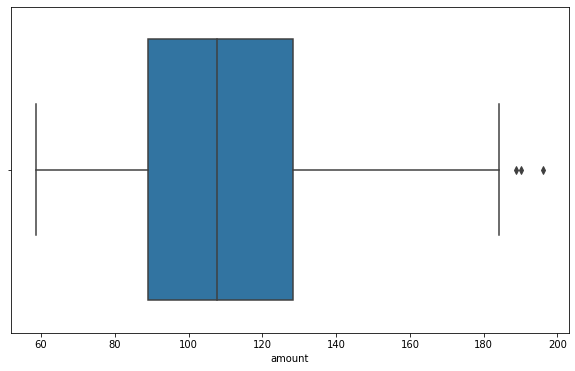

In [13]:
ax = sns.boxplot(x=df['amount'])

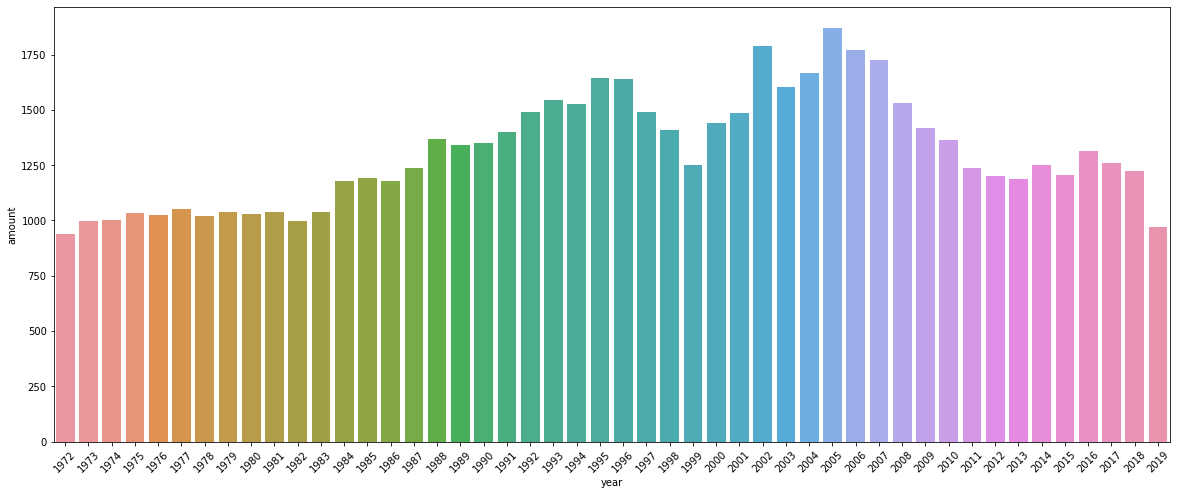

In [14]:
plt.figure(figsize=(20, 8))
sns.barplot(x='year', y='amount', data=df, ci=None, estimator=sum)
plt.xticks(rotation=45);

In [15]:
fig = px.bar(df, x='year', y='amount', 
             color='month', 
             title='Montly Product Amount By Year',
             color_continuous_scale='Bluered_r')

fig.show()

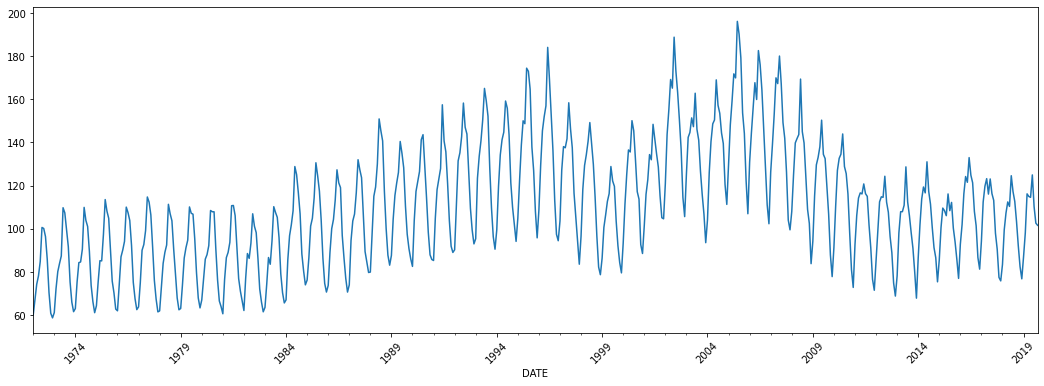

In [16]:
df['amount'].plot(figsize=(18, 6))
plt.xticks(rotation=45);

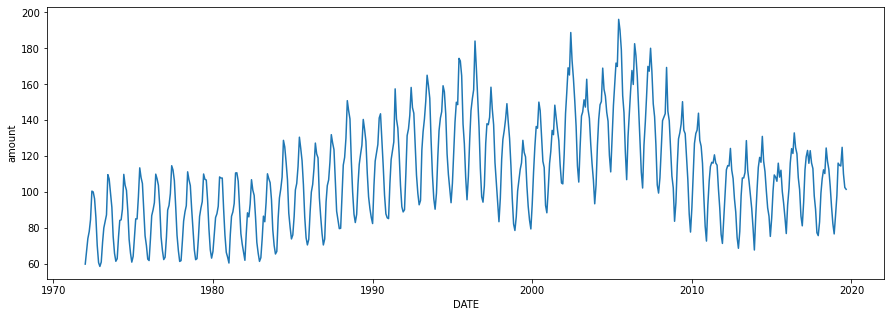

In [17]:
date_cnt = df.groupby("date")["amount"].sum()

plt.figure(figsize=(15,5))
sns.lineplot(x=df.index, y=df["amount"]);

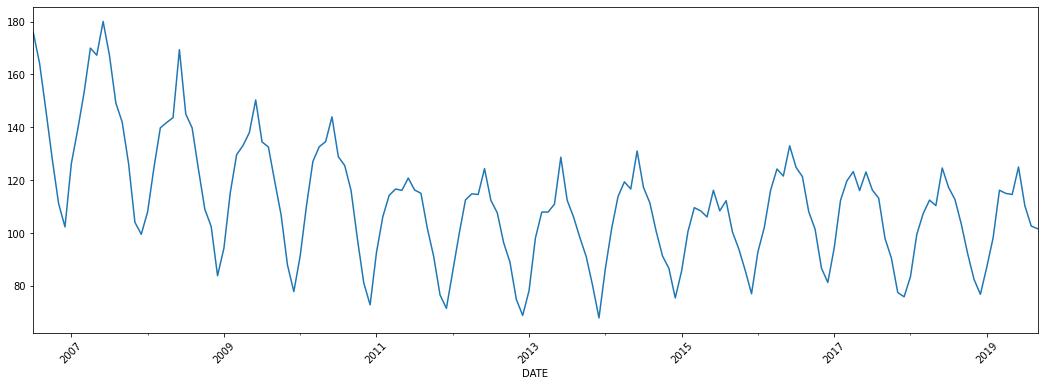

In [18]:
df['amount'].loc["2006-06-30":"2019-09-01"].plot(figsize=(18, 6))
plt.xticks(rotation=45);

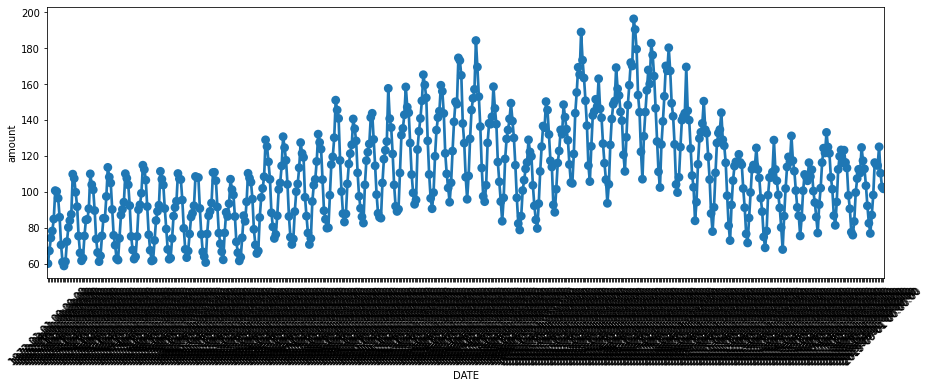

In [19]:
data_by_month = df.resample('M').sum()

plt.figure(figsize=(15, 5))
plt.xticks(rotation=45)
sns.pointplot(x=df.index, y=df["amount"]);

In [20]:
fig = px.line(df, x='year', y='amount', color='month', markers=True)
fig.show()

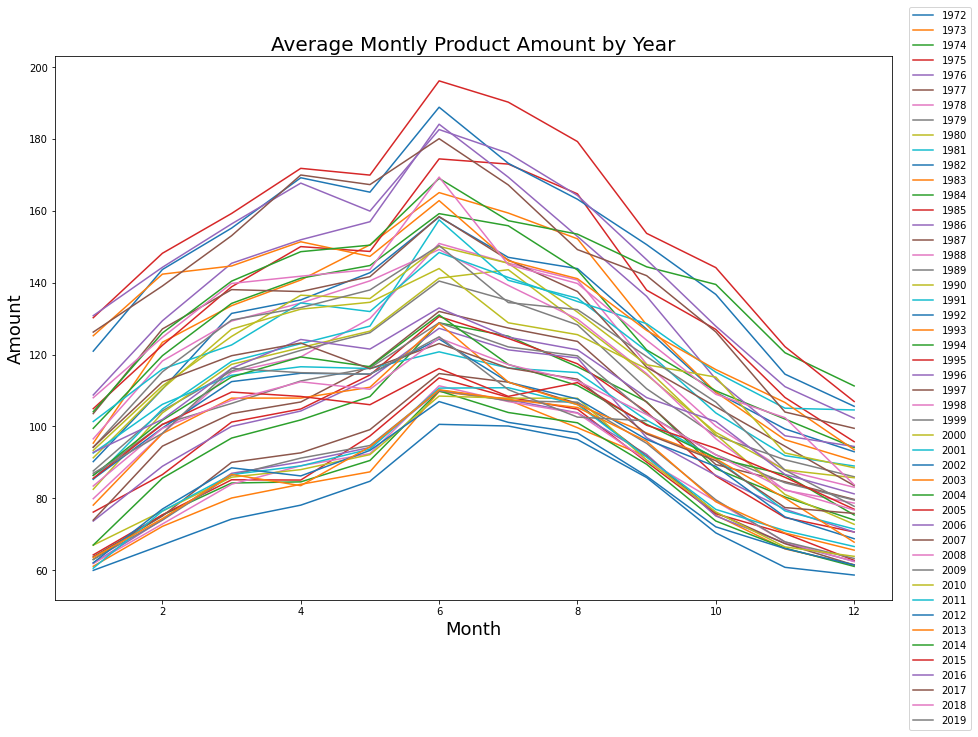

In [21]:
year_month_cnt = df.groupby(["year", "month"])["amount"].mean()

plt.figure(figsize=(15, 10))
for year in year_month_cnt.index.levels[0]:
    plt.plot(year_month_cnt[year].index, year_month_cnt[year], label=year)


plt.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1))
plt.xlabel('Month', fontsize=18)
plt.ylabel('Amount', fontsize=18)
plt.title('Average Montly Product Amount by Year', fontsize=20)
plt.show()

<a id="4.2"></a>
### <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:LEFT; border-radius:10px 10px;">4.2 Handling With Missing Values</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

**Missing data (or missing values) is defined as the data value that is not stored for a variable in the observation of interest. The problem of missing data is relatively common in almost all research and can have a significant effect on the conclusions that can be drawn from the data. Accordingly, all studies need to focus on handling the missing data, problems caused by missing data, and the methods to avoid or minimize their effects on the analysis. Otherwise, missing data can reduce the statistical power of a study and can produce biased estimates, leading to invalid conclusions.**

**For a better understanding and more information how to handle with missing values in Machine Learning, please refer to [external link text](https://machinelearningmastery.com/handle-missing-data-python/) & [external link text](https://www.kaggle.com/kaanboke/the-most-used-methods-to-deal-with-missing-values)**

**A General Look At The Missing Values**

In [22]:
missing_values(df)

,Missing_Number,Missing_Percent


**Fortunately we have NO missing values which is NOT case in real life.**

**Let's examine missing values visually.**

<Figure size 288x432 with 0 Axes>

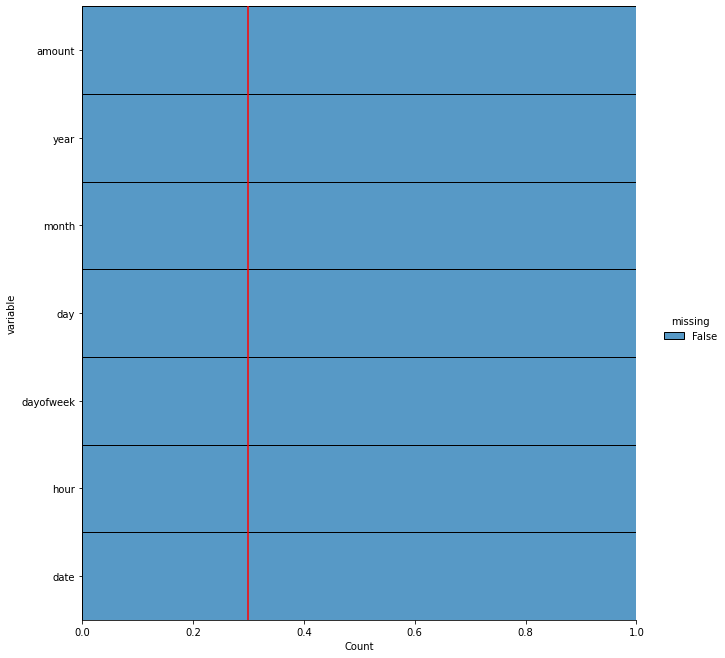

In [23]:
plt.figure(figsize=(4, 6))

sns.displot(data=df.isnull().melt(value_name="missing"),
            y="variable",
            hue="missing",
            multiple="fill",
            height=9.25)

plt.axvline(0.3, color="r");

**Drop unnecessary columns.**

In [24]:
df.head()

,amount,year,month,day,dayofweek,hour,date
DATE,,,,,,,
1972-01-01,59.962,1972,1,1,5,0,1972-01-01
1972-02-01,67.061,1972,2,1,1,0,1972-02-01
1972-03-01,74.235,1972,3,1,2,0,1972-03-01
1972-04-01,78.112,1972,4,1,5,0,1972-04-01
1972-05-01,84.764,1972,5,1,0,0,1972-05-01


In [25]:
df.columns

Index(['amount', 'year', 'month', 'day', 'dayofweek', 'hour', 'date'], dtype='object')

In [26]:
df = df.drop(['year', 'month', 'day', 'dayofweek', 'hour', 'date'], axis=1)

In [27]:
df.head()

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


<a id="5"></a>
## <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:center; border-radius:10px 10px;">5 - DATA PREPROCESSING</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

<a id="5.1"></a>
### <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:LEFT; border-radius:10px 10px;">5.1 Train|Test Split Operations</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

In [28]:
len(df)

573

In [29]:
len(df) - 48

525

In [30]:
test_size = 48 

In [31]:
test_ind = len(df) - test_size

In [32]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [33]:
train

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
1972-06-01,100.596
1972-07-01,100.126
1972-08-01,96.361
1972-09-01,85.801


In [34]:
test

,amount
DATE,
2015-10-01,93.932
2015-11-01,85.864
2015-12-01,76.975
2016-01-01,92.811
2016-02-01,101.974
2016-03-01,116.179
2016-04-01,124.211
2016-05-01,121.543
2016-06-01,132.987


<a id="5.2"></a>
### <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:LEFT; border-radius:10px 10px;">5.2 Scaling Operation</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

In [35]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

**MinMaxScaler is preferred for collecting data in a narrower range and for faster speed. So let's do it.**

**For a better understanding and more information, please refer to [external link text](https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/) & [external link text](https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/)**

In [36]:
scaler = StandardScaler()

In [37]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [38]:
train_scaled

array([[-1.75378199e+00],
       [-1.50685367e+00],
       [-1.25727458e+00],
       [-1.12240552e+00],
       [-8.91016533e-01],
       [-3.40255375e-01],
       [-3.56594813e-01],
       [-4.87588611e-01],
       [-8.54938971e-01],
       [-1.39091219e+00],
       [-1.72438700e+00],
       [-1.79908853e+00],
       [-1.71421529e+00],
       [-1.32785038e+00],
       [-1.05330469e+00],
       [-9.20853314e-01],
       [-8.00306041e-01],
       [-2.19302864e-02],
       [-1.04441491e-01],
       [-3.72708135e-01],
       [-6.52252714e-01],
       [-1.22005601e+00],
       [-1.54603423e+00],
       [-1.69922907e+00],
       [-1.64881580e+00],
       [-1.21867149e+00],
       [-9.08246517e-01],
       [-8.97114688e-01],
       [-6.90090497e-01],
       [-1.65104771e-02],
       [-2.25656673e-01],
       [-3.25279586e-01],
       [-7.27079478e-01],
       [-1.27605259e+00],
       [-1.53827326e+00],
       [-1.71540849e+00],
       [-1.60406932e+00],
       [-1.21614247e+00],
       [-8.7

In [39]:
len(train_scaled)

525

In [40]:
test_scaled

array([[-5.72086151e-01],
       [-8.52736956e-01],
       [-1.16196177e+00],
       [-6.11089298e-01],
       [-2.92308500e-01],
       [ 2.01840350e-01],
       [ 4.81224909e-01],
       [ 3.88444593e-01],
       [ 7.86511843e-01],
       [ 5.03516397e-01],
       [ 3.81090628e-01],
       [-8.14438276e-02],
       [-3.12857161e-01],
       [-8.24883032e-01],
       [-1.01300399e+00],
       [-5.61173480e-01],
       [ 6.99490479e-02],
       [ 3.24252204e-01],
       [ 4.47050194e-01],
       [ 1.97812020e-01],
       [ 4.42138274e-01],
       [ 2.04783328e-01],
       [ 9.72150717e-02],
       [-4.33606198e-01],
       [-6.92396873e-01],
       [-1.14585889e+00],
       [-1.20242249e+00],
       [-9.37258847e-01],
       [-3.78733238e-01],
       [-1.06514794e-01],
       [ 7.14448874e-02],
       [-7.90247221e-04],
       [ 4.94217841e-01],
       [ 2.38095326e-01],
       [ 8.00372680e-02],
       [-2.45780933e-01],
       [-6.34688775e-01],
       [-9.72031898e-01],
       [-1.1

In [41]:
len(test_scaled)

48

<a id="5.3"></a>
### <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:LEFT; border-radius:10px 10px;">5.3 Time Series Generator</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

In [42]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [43]:
# If you want to get more information about Time Series Generator, run the following code by uncommenting it

# help(TimeseriesGenerator)

In [44]:
length = 24

generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 1)

In [45]:
generator[0]

(array([[[-1.75378199],
         [-1.50685367],
         [-1.25727458],
         [-1.12240552],
         [-0.89101653],
         [-0.34025537],
         [-0.35659481],
         [-0.48758861],
         [-0.85493897],
         [-1.39091219],
         [-1.724387  ],
         [-1.79908853],
         [-1.71421529],
         [-1.32785038],
         [-1.05330469],
         [-0.92085331],
         [-0.80030604],
         [-0.02193029],
         [-0.10444149],
         [-0.37270814],
         [-0.65225271],
         [-1.22005601],
         [-1.54603423],
         [-1.69922907]]]),
 array([[-1.6488158]]))

In [46]:
train_scaled

array([[-1.75378199e+00],
       [-1.50685367e+00],
       [-1.25727458e+00],
       [-1.12240552e+00],
       [-8.91016533e-01],
       [-3.40255375e-01],
       [-3.56594813e-01],
       [-4.87588611e-01],
       [-8.54938971e-01],
       [-1.39091219e+00],
       [-1.72438700e+00],
       [-1.79908853e+00],
       [-1.71421529e+00],
       [-1.32785038e+00],
       [-1.05330469e+00],
       [-9.20853314e-01],
       [-8.00306041e-01],
       [-2.19302864e-02],
       [-1.04441491e-01],
       [-3.72708135e-01],
       [-6.52252714e-01],
       [-1.22005601e+00],
       [-1.54603423e+00],
       [-1.69922907e+00],
       [-1.64881580e+00],
       [-1.21867149e+00],
       [-9.08246517e-01],
       [-8.97114688e-01],
       [-6.90090497e-01],
       [-1.65104771e-02],
       [-2.25656673e-01],
       [-3.25279586e-01],
       [-7.27079478e-01],
       [-1.27605259e+00],
       [-1.53827326e+00],
       [-1.71540849e+00],
       [-1.60406932e+00],
       [-1.21614247e+00],
       [-8.7

In [47]:
X, y = generator[0]

In [48]:
X

array([[[-1.75378199],
        [-1.50685367],
        [-1.25727458],
        [-1.12240552],
        [-0.89101653],
        [-0.34025537],
        [-0.35659481],
        [-0.48758861],
        [-0.85493897],
        [-1.39091219],
        [-1.724387  ],
        [-1.79908853],
        [-1.71421529],
        [-1.32785038],
        [-1.05330469],
        [-0.92085331],
        [-0.80030604],
        [-0.02193029],
        [-0.10444149],
        [-0.37270814],
        [-0.65225271],
        [-1.22005601],
        [-1.54603423],
        [-1.69922907]]])

In [49]:
X.flatten()

array([-1.75378199, -1.50685367, -1.25727458, -1.12240552, -0.89101653,
       -0.34025537, -0.35659481, -0.48758861, -0.85493897, -1.39091219,
       -1.724387  , -1.79908853, -1.71421529, -1.32785038, -1.05330469,
       -0.92085331, -0.80030604, -0.02193029, -0.10444149, -0.37270814,
       -0.65225271, -1.22005601, -1.54603423, -1.69922907])

In [50]:
y

array([[-1.6488158]])

In [51]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[-1.75378199 -1.50685367 -1.25727458 -1.12240552 -0.89101653 -0.34025537
 -0.35659481 -0.48758861 -0.85493897 -1.39091219 -1.724387   -1.79908853
 -1.71421529 -1.32785038 -1.05330469 -0.92085331 -0.80030604 -0.02193029
 -0.10444149 -0.37270814 -0.65225271 -1.22005601 -1.54603423 -1.69922907]
Predict this y: 
 [[-1.6488158]]


<a id="6"></a>
## <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:center; border-radius:10px 10px;">6 - MODELLING & MODEL PERFORMANCE</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

<a id="6.1"></a>
### <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:LEFT; border-radius:10px 10px;">6.1 Creating Model</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

<a id="6.1.1a"></a>
#### <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:LEFT; border-radius:10px 10px;">6.1.1a Modelling With "tanh" Activation Function</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [53]:
n_features = 1

In [54]:
model = Sequential()
model.add(LSTM(55, activation = 'tanh', input_shape = (length, n_features))) 
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 55)                12540     
_________________________________________________________________
dense (Dense)                (None, 1)                 56        
Total params: 12,596
Trainable params: 12,596
Non-trainable params: 0
_________________________________________________________________


<a id="6.1.1b"></a>
#### <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:LEFT; border-radius:10px 10px;">6.1.1b EarlyStopping and Validation Generator</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

In [56]:
from tensorflow.keras.callbacks import EarlyStopping

In [57]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

In [58]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)

In [59]:
len(validation_generator)

24

In [60]:
model.fit_generator(generator, epochs = 50,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/50
501/501 [==============================] - 7s 9ms/step - loss: 0.3675 - val_loss: 0.0432
Epoch 2/50
501/501 [==============================] - 4s 8ms/step - loss: 0.0783 - val_loss: 0.0545
Epoch 3/50
501/501 [==============================] - 4s 9ms/step - loss: 0.0619 - val_loss: 0.0497
Epoch 4/50
501/501 [==============================] - 5s 10ms/step - loss: 0.0559 - val_loss: 0.0458
Epoch 5/50
501/501 [==============================] - 4s 9ms/step - loss: 0.0531 - val_loss: 0.0433
Epoch 6/50
501/501 [==============================] - 5s 10ms/step - loss: 0.0536 - val_loss: 0.0559
Epoch 7/50
501/501 [==============================] - 5s 9ms/step - loss: 0.0527 - val_loss: 0.0379
Epoch 8/50
501/501 [==============================] - 5s 10ms/step - loss: 0.0445 - val_loss: 0.0589
Epoch 9/50
501/501 [==============================] - 5s 10ms/step - loss: 0.0435 - val_loss: 0.0327
Epoch 10/50
501/501 [==============================] - 6s 11ms/step - loss: 0.0415 - val_loss: 0

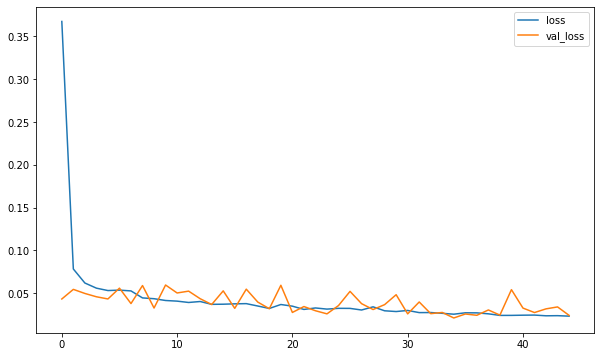

In [61]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot();

<a id="6.1.1c"></a>
#### <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:LEFT; border-radius:10px 10px;">6.1.1c Evaluation on Test Data</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [63]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [64]:
y_pred = model.predict(validation_generator)

In [65]:
y_pred

array([[-0.6436996 ],
       [-0.86105114],
       [-1.2205418 ],
       [-0.76246154],
       [-0.38812026],
       [-0.11501858],
       [-0.10695703],
       [ 0.20017818],
       [ 0.36639366],
       [ 0.19826654],
       [ 0.14624292],
       [-0.32591438],
       [-0.58254755],
       [-0.9182365 ],
       [-1.1370293 ],
       [-0.77177227],
       [-0.20334023],
       [-0.0242407 ],
       [ 0.19402862],
       [ 0.23757762],
       [ 0.6694655 ],
       [ 0.31828788],
       [-0.00141829],
       [-0.50799686]], dtype=float32)

In [66]:
len(y_pred)

24

In [67]:
test_scaled[-24:]

array([[-6.92396873e-01],
       [-1.14585889e+00],
       [-1.20242249e+00],
       [-9.37258847e-01],
       [-3.78733238e-01],
       [-1.06514794e-01],
       [ 7.14448874e-02],
       [-7.90247221e-04],
       [ 4.94217841e-01],
       [ 2.38095326e-01],
       [ 8.00372680e-02],
       [-2.45780933e-01],
       [-6.34688775e-01],
       [-9.72031898e-01],
       [-1.16940966e+00],
       [-8.13260707e-01],
       [-4.26680113e-01],
       [ 2.01579448e-01],
       [ 1.59782909e-01],
       [ 1.45555039e-01],
       [ 5.07311655e-01],
       [-3.96281851e-03],
       [-2.70246606e-01],
       [-3.05795407e-01]])

In [68]:
eval_metrics(test_scaled[-24:], y_pred)

r2_score: 0.9101292734765152 
 mae: 0.12284762322012484 
 mse: 0.02406947674884369 
 rmse: 0.15514340704278637


In [69]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [70]:
train.shape

(525, 1)

In [71]:
eval_metrics(test_scaled, test_predictions)

r2_score: -0.2104693888125515 
 mae: 0.4665441333181335 
 mse: 0.3532697224306975 
 rmse: 0.5943649740947876


<a id="6.1.1d"></a>
#### <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:LEFT; border-radius:10px 10px;">6.1.1d Inverse Transformations & Comparion</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

In [72]:
test_predictions

[array([-0.63539964], dtype=float32),
 array([-0.877073], dtype=float32),
 array([-1.0938225], dtype=float32),
 array([-0.8373313], dtype=float32),
 array([-0.24224406], dtype=float32),
 array([0.11804847], dtype=float32),
 array([0.2069368], dtype=float32),
 array([0.27237946], dtype=float32),
 array([0.73503333], dtype=float32),
 array([0.47035846], dtype=float32),
 array([0.3566512], dtype=float32),
 array([-0.02160586], dtype=float32),
 array([-0.36126587], dtype=float32),
 array([-0.6262344], dtype=float32),
 array([-0.8575974], dtype=float32),
 array([-0.58574367], dtype=float32),
 array([0.01078738], dtype=float32),
 array([0.33493423], dtype=float32),
 array([0.40372297], dtype=float32),
 array([0.44171184], dtype=float32),
 array([0.9064757], dtype=float32),
 array([0.6389027], dtype=float32),
 array([0.5351298], dtype=float32),
 array([0.23090312], dtype=float32),
 array([-0.09097857], dtype=float32),
 array([-0.35590687], dtype=float32),
 array([-0.60357255], dtype=float32),

In [73]:
tanh_true_preds = scaler.inverse_transform(test_predictions)

In [74]:
test['Predictions_Tanh'] = tanh_true_preds

In [75]:
test

,amount,Predictions_Tanh
DATE,,
2015-10-01,93.932,92.112
2015-11-01,85.864,85.164
2015-12-01,76.975,78.934
2016-01-01,92.811,86.307
2016-02-01,101.974,103.413
2016-03-01,116.179,113.771
2016-04-01,124.211,116.326
2016-05-01,121.543,118.207
2016-06-01,132.987,131.507


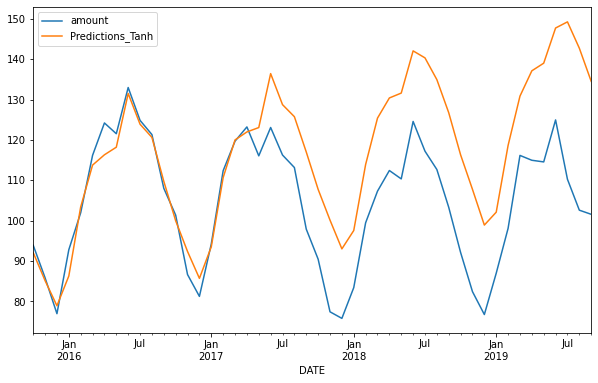

In [76]:
test.plot();

<a id="6.1.1e"></a>
#### <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:LEFT; border-radius:10px 10px;">6.1.1e Calculation of R2 Score & Error Metrics</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

In [77]:
eval_metrics(test.amount, test.Predictions_Tanh)

r2_score: -0.21046935067445793 
 mae: 13.411463589731852 
 mse: 291.92635278715875 
 rmse: 17.085852416170482


<a id="6.1.2"></a>
#### <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:LEFT; border-radius:10px 10px;">6.1.2 Modelling With "relu" Activation Function</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

<a id="6.1.2a"></a>
#### <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:LEFT; border-radius:10px 10px;">6.1.2a Modelling With "relu" Activation Function</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [79]:
n_features = 1

In [80]:
model = Sequential()
model.add(LSTM(60, activation = 'relu', input_shape = (length, n_features))) 
model.add(Dense(1))  
model.compile(optimizer = 'adam', loss = 'mse')

In [81]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60)                14880     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 61        
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


<a id="6.1.2b"></a>
#### <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:LEFT; border-radius:10px 10px;">6.1.2b EarlyStopping and Validation Generator</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

In [82]:
from tensorflow.keras.callbacks import EarlyStopping

In [83]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

In [84]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)

In [85]:
len(validation_generator)

24

In [86]:
model.fit_generator(generator, epochs = 50,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/50
501/501 [==============================] - 5s 8ms/step - loss: 0.5666 - val_loss: 0.2931
Epoch 2/50
501/501 [==============================] - 4s 8ms/step - loss: 0.4838 - val_loss: 0.2252
Epoch 3/50
501/501 [==============================] - 4s 8ms/step - loss: 0.4829 - val_loss: 0.2130
Epoch 4/50
501/501 [==============================] - 4s 8ms/step - loss: 0.3246 - val_loss: 0.0867
Epoch 5/50
501/501 [==============================] - 4s 8ms/step - loss: 0.1521 - val_loss: 0.0702
Epoch 6/50
501/501 [==============================] - 4s 7ms/step - loss: 0.0893 - val_loss: 0.0442
Epoch 7/50
501/501 [==============================] - 4s 8ms/step - loss: 0.0746 - val_loss: 0.0444
Epoch 8/50
501/501 [==============================] - 4s 7ms/step - loss: 0.0695 - val_loss: 0.0476
Epoch 9/50
501/501 [==============================] - 4s 7ms/step - loss: 0.0641 - val_loss: 0.0461
Epoch 10/50
501/501 [==============================] - 4s 8ms/step - loss: 0.0644 - val_loss: 0.0743

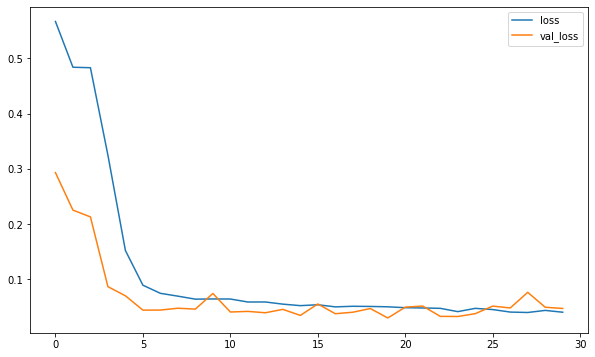

In [87]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot();

<a id="6.1.2c"></a>
#### <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:LEFT; border-radius:10px 10px;">6.1.2c Evaluation on Test Data</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

In [88]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [89]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [90]:
y_pred = model.predict(validation_generator)

In [91]:
y_pred

array([[-0.8177444 ],
       [-1.0221374 ],
       [-1.2153679 ],
       [-0.65701306],
       [-0.37251288],
       [-0.01061852],
       [ 0.24840772],
       [ 0.4781041 ],
       [ 0.4020403 ],
       [ 0.3649665 ],
       [ 0.00293028],
       [-0.32911777],
       [-0.7185853 ],
       [-1.0404994 ],
       [-1.100326  ],
       [-0.62620944],
       [-0.14051415],
       [ 0.05533779],
       [ 0.43690294],
       [ 0.5647439 ],
       [ 0.540586  ],
       [ 0.45370424],
       [-0.10678746],
       [-0.5745517 ]], dtype=float32)

In [92]:
len(y_pred)

24

In [93]:
len(test_scaled)

48

In [94]:
test_scaled[-24:]

array([[-6.92396873e-01],
       [-1.14585889e+00],
       [-1.20242249e+00],
       [-9.37258847e-01],
       [-3.78733238e-01],
       [-1.06514794e-01],
       [ 7.14448874e-02],
       [-7.90247221e-04],
       [ 4.94217841e-01],
       [ 2.38095326e-01],
       [ 8.00372680e-02],
       [-2.45780933e-01],
       [-6.34688775e-01],
       [-9.72031898e-01],
       [-1.16940966e+00],
       [-8.13260707e-01],
       [-4.26680113e-01],
       [ 2.01579448e-01],
       [ 1.59782909e-01],
       [ 1.45555039e-01],
       [ 5.07311655e-01],
       [-3.96281851e-03],
       [-2.70246606e-01],
       [-3.05795407e-01]])

In [95]:
eval_metrics(test_scaled[-24:], y_pred)

r2_score: 0.8235943808955776 
 mae: 0.1725041242381559 
 mse: 0.04724553936135948 
 rmse: 0.21736039050700906


In [96]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [97]:
test_scaled

array([[-5.72086151e-01],
       [-8.52736956e-01],
       [-1.16196177e+00],
       [-6.11089298e-01],
       [-2.92308500e-01],
       [ 2.01840350e-01],
       [ 4.81224909e-01],
       [ 3.88444593e-01],
       [ 7.86511843e-01],
       [ 5.03516397e-01],
       [ 3.81090628e-01],
       [-8.14438276e-02],
       [-3.12857161e-01],
       [-8.24883032e-01],
       [-1.01300399e+00],
       [-5.61173480e-01],
       [ 6.99490479e-02],
       [ 3.24252204e-01],
       [ 4.47050194e-01],
       [ 1.97812020e-01],
       [ 4.42138274e-01],
       [ 2.04783328e-01],
       [ 9.72150717e-02],
       [-4.33606198e-01],
       [-6.92396873e-01],
       [-1.14585889e+00],
       [-1.20242249e+00],
       [-9.37258847e-01],
       [-3.78733238e-01],
       [-1.06514794e-01],
       [ 7.14448874e-02],
       [-7.90247221e-04],
       [ 4.94217841e-01],
       [ 2.38095326e-01],
       [ 8.00372680e-02],
       [-2.45780933e-01],
       [-6.34688775e-01],
       [-9.72031898e-01],
       [-1.1

In [98]:
test_predictions

[array([-0.8317765], dtype=float32),
 array([-1.2269992], dtype=float32),
 array([-1.4397715], dtype=float32),
 array([-0.9731058], dtype=float32),
 array([-0.37696743], dtype=float32),
 array([-0.02565473], dtype=float32),
 array([0.2991362], dtype=float32),
 array([0.61226356], dtype=float32),
 array([0.8235687], dtype=float32),
 array([0.6886914], dtype=float32),
 array([0.30318528], dtype=float32),
 array([-0.18942784], dtype=float32),
 array([-0.68262047], dtype=float32),
 array([-1.1039133], dtype=float32),
 array([-1.2384142], dtype=float32),
 array([-0.74241394], dtype=float32),
 array([-0.15803213], dtype=float32),
 array([0.13008726], dtype=float32),
 array([0.35606545], dtype=float32),
 array([0.5900297], dtype=float32),
 array([0.8070015], dtype=float32),
 array([0.6340437], dtype=float32),
 array([0.3036005], dtype=float32),
 array([-0.20635541], dtype=float32),
 array([-0.74577945], dtype=float32),
 array([-1.1959955], dtype=float32),
 array([-1.3881639], dtype=float32),


In [99]:
eval_metrics(test_scaled, test_predictions)

r2_score: 0.6021079768522672 
 mae: 0.26912094834293876 
 mse: 0.11612289073470759 
 rmse: 0.3407680893726811


<a id="6.1.2d"></a>
#### <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:LEFT; border-radius:10px 10px;">6.1.2d Inverse Transformations & Comparion</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

In [100]:
relu_true_preds = scaler.inverse_transform(test_predictions)

In [101]:
test['Predictions_Relu'] = relu_true_preds

In [102]:
test

,amount,Predictions_Tanh,Predictions_Relu
DATE,,,
2015-10-01,93.932,92.112,86.467
2015-11-01,85.864,85.164,75.105
2015-12-01,76.975,78.934,68.989
2016-01-01,92.811,86.307,82.404
2016-02-01,101.974,103.413,99.541
2016-03-01,116.179,113.771,109.640
2016-04-01,124.211,116.326,118.976
2016-05-01,121.543,118.207,127.977
2016-06-01,132.987,131.507,134.052


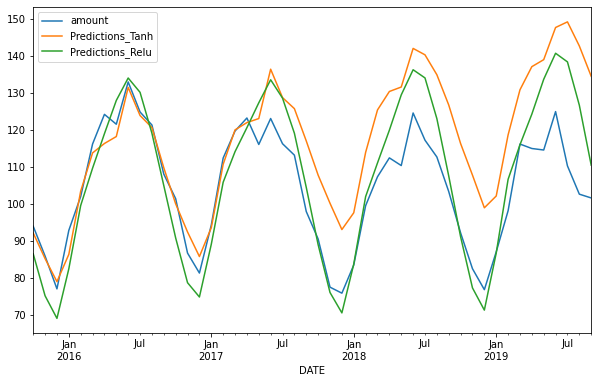

In [103]:
test.plot();

<a id="6.1.2e"></a>
#### <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:LEFT; border-radius:10px 10px;">6.1.2e Calculation of R2 Score & Error Metrics</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

In [104]:
eval_metrics(test.amount, test.Predictions_Relu)

r2_score: 0.6021079661084529 
 mae: 7.736258678181966 
 mse: 95.95878672376443 
 rmse: 9.795855589164452


<a id="6.2"></a>
### <p style="background-color:#9c2162; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:LEFT; border-radius:10px 10px;">6.2 Retrain & Forecasting</p>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#e9a1ed" data-toggle="popover">Table of Contents</a>

**Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.**

In [122]:
full_scaler = StandardScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [123]:
length = 24 
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [124]:
model = Sequential()
model.add(LSTM(55, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=50)

Epoch 1/50
549/549 [==============================] - 6s 8ms/step - loss: 0.5365
Epoch 2/50
549/549 [==============================] - 4s 8ms/step - loss: 0.3775A: 0s - loss: 
Epoch 3/50
549/549 [==============================] - 4s 8ms/step - loss: 0.2547
Epoch 4/50
549/549 [==============================] - 4s 8ms/step - loss: 0.0870
Epoch 5/50
549/549 [==============================] - 4s 8ms/step - loss: 0.0789A: 1s -
Epoch 6/50
549/549 [==============================] - 5s 9ms/step - loss: 0.0724
Epoch 7/50
549/549 [==============================] - 5s 8ms/step - loss: 0.0681A: 0s - l
Epoch 8/50
549/549 [==============================] - 5s 9ms/step - loss: 0.0657
Epoch 9/50
549/549 [==============================] - 4s 8ms/step - loss: 0.0631A: 0s - loss: 0.063
Epoch 10/50
549/549 [==============================] - 5s 8ms/step - loss: 0.0595
Epoch 11/50
549/549 [==============================] - 4s 8ms/step - loss: 0.0580
Epoch 12/50
549/549 [==============================] - 5s 

In [125]:
scaled_full_data.shape

(573, 1)

In [126]:
scaled_full_data[-length:].shape

(24, 1)

In [127]:
forecast = []

# Replace periods with whatever forecast length you want
periods = 24

first_eval_batch = scaled_full_data[-length:] 
# tüm datamın son 12 ye 1 lik kısmını aldım. artık bunu ileriye doğru predict te (forecast) kullanıcam
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)
    
# Burada tüm datamızın sonundan 12lik bir parçayı aldık. bu bizim ilk eval_batch imiz olacak. 
# sonra bunu reshape yaptık (1,12,1) oldu  ( (1, length, n_features) )
# bundan for döngüsü içinde current_batch i hep bir ilerletecek şekilde predict ler alıp alıp forecast e kaydettim. 

In [128]:
forecast = scaler.inverse_transform(forecast)

In [129]:
forecast

array([[ 90.86723 ],
       [ 82.66151 ],
       [ 78.56382 ],
       [ 85.83972 ],
       [ 99.80476 ],
       [107.85335 ],
       [110.32561 ],
       [114.29353 ],
       [120.209564],
       [115.982544],
       [108.96338 ],
       [ 99.4544  ],
       [ 89.71372 ],
       [ 81.66295 ],
       [ 78.25535 ],
       [ 87.643036],
       [102.43964 ],
       [111.30696 ],
       [113.78874 ],
       [118.763214],
       [123.17687 ],
       [116.75733 ],
       [108.740685],
       [ 99.31176 ]], dtype=float32)

In [130]:
df

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
1972-06-01,100.596
1972-07-01,100.126
1972-08-01,96.361
1972-09-01,85.801


In [131]:
forecast_index = pd.date_range(start = '2019-10-01', periods = periods, freq = 'MS')

In [132]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [133]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

# forecast lerden dataframe oluşturduk

In [134]:
forecast_df

,Forecast
2019-10-01,90.867
2019-11-01,82.662
2019-12-01,78.564
2020-01-01,85.840
2020-02-01,99.805
2020-03-01,107.853
2020-04-01,110.326
2020-05-01,114.294
2020-06-01,120.210
2020-07-01,115.983


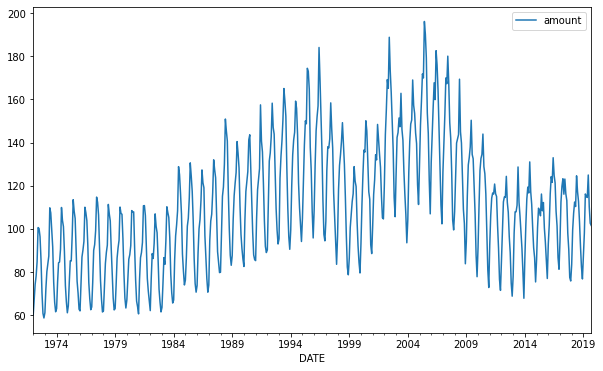

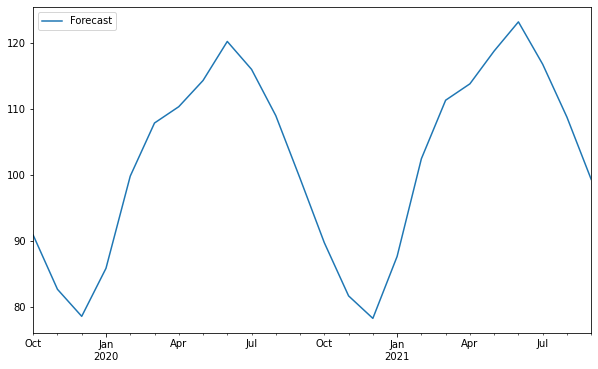

In [135]:
df.plot();
forecast_df.plot();

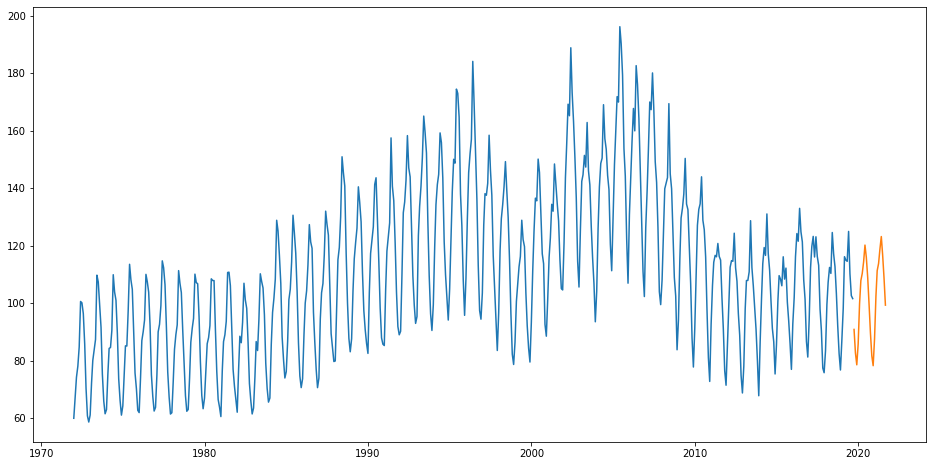

In [136]:
plt.figure(figsize = (16, 8))

plt.plot(df.index, df['amount']);
plt.plot(forecast_df.index, forecast_df['Forecast']);
#plt.plot(forecast_index, forecast)

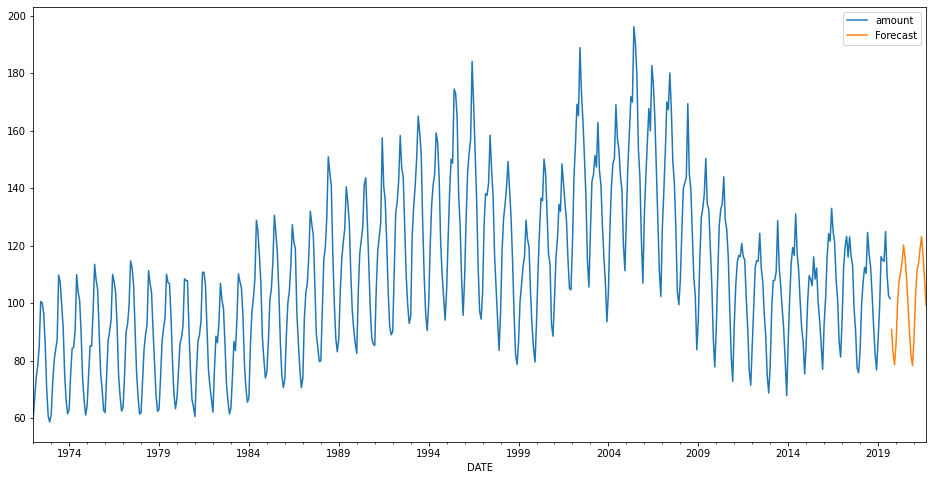

In [137]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

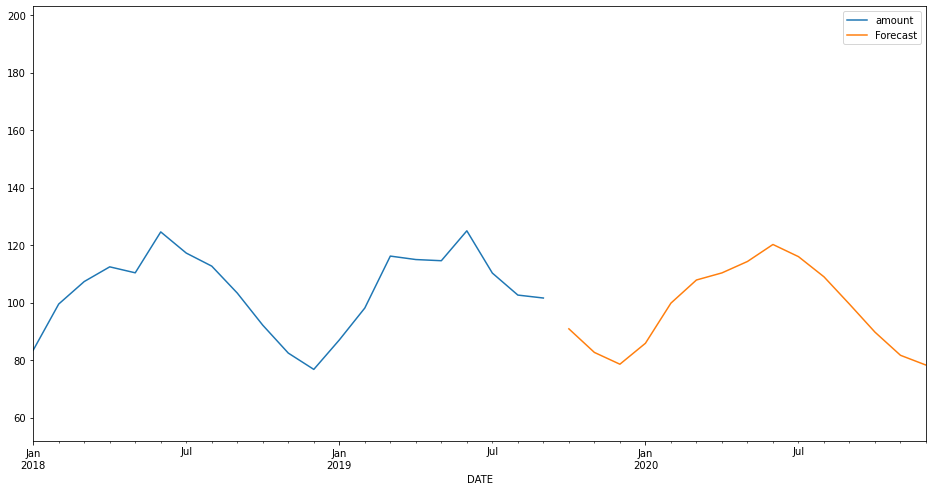

In [138]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2020-12-01');